# Loading Libraries

In [1]:

def View(df, rows=None, cols=None, width=None):
    """Displays the first `rows` of the DataFrame like R's View() by adjusting Pandas settings."""
    
    # Show only the first `rows` of the DataFrame
    with pd.option_context(
        "display.max_rows", rows,  # Limit number of rows shown
        "display.max_columns", cols,  # Show all columns
        "display.max_colwidth", width,  # Show full column width
        "display.expand_frame_repr", False  # Prevent column wrapping
    ):
        display(df.head(rows))  # Show only the first `rows`
import pickle
import shap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# File paths
fp_simple = '/gpfs/milgram/project/rtaylor/imc33/LOS/output/model_simple.pkl'
fp_val = '/gpfs/milgram/project/rtaylor/imc33/LOS/output/X_val_selected.csv'
lab_df = pd.read_csv('/gpfs/milgram/project/rtaylor/imc33/LOS/data/new_label_names.csv')

# Create rename dictionary from lab_df
rename_dict = pd.Series(lab_df.new_name.values, index=lab_df.old_name).to_dict()

# Load the model
with open(fp_simple, "rb") as f:
    model = pickle.load(f)

# Load dataset
X_test = pd.read_csv(fp_val, index_col='pat_enc_csn_id')

# Ensure feature order matches what the model expects
#X_test = X_test[model.feature_names_in_]

# Confirm features are identical
#print("Feature order matches:", list(model.feature_names_in_) == list(X_test.columns))

# Rename feature columns using rename_dict while ensuring uniqueness
X_test = X_test.rename(columns=rename_dict)

# Check for duplicate column names and resolve by appending a suffix
counts = {}
new_columns = []
for col in X_test.columns:
    if col in counts:
        counts[col] += 1
        new_columns.append(f"{col} ({counts[col]})")  # Append count to make unique
    else:
        counts[col] = 1
        new_columns.append(col)

X_test.columns = new_columns  # Update column names to be unique


# Calulate SHAP

In [2]:
# Compute SHAP values
explainer = shap.TreeExplainer(model, feature_perturbation="tree_path_dependent")
shap_values = explainer(X_test)  # Compute SHAP values

# Ensure SHAP values use the renamed features
shap_values.feature_names = X_test.columns.tolist()

# Importance DF

In [3]:
# Calculate the mean absolute SHAP value for each feature
mean_abs_shap = np.abs(shap_values.values).mean(axis=0)

# Create a DataFrame for feature importance
importance_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Mean Absolute SHAP': mean_abs_shap
})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Mean Absolute SHAP', ascending=False)

importance_df

,Feature,Mean Absolute SHAP
3,Consult Count,0.429263
166,Not Ready for Discharge_First,0.246893
54,Discharged Home,0.115305
43,Imaging Count,0.106140
76,DRG Severe Respiratory Infection,0.101749
...,...,...
28,con_service_otolaryngology_ent_count,0.000758
17,con_service_hepatology_count,0.000742
26,con_service_orthopedics_count,0.000729
11,con_service_cardiothoracic_surgery_count,0.000341


In [4]:
df = importance_df.copy()

In [5]:
filtered_df = df[df['Feature'].str.contains(r'count|volume|age', case=False, na=False, regex=True)]


In [6]:
filtered_df = filtered_df[~filtered_df["Feature"].isin(["viz_insurance_Managed Medicare","viz_language_Other"])]

In [7]:
filtered_df.to_csv("../output/numeric_features.csv", index=False)

In [8]:
importance_df.to_csv("../output/all_features.csv", index=False)

# Beeswarm Plot

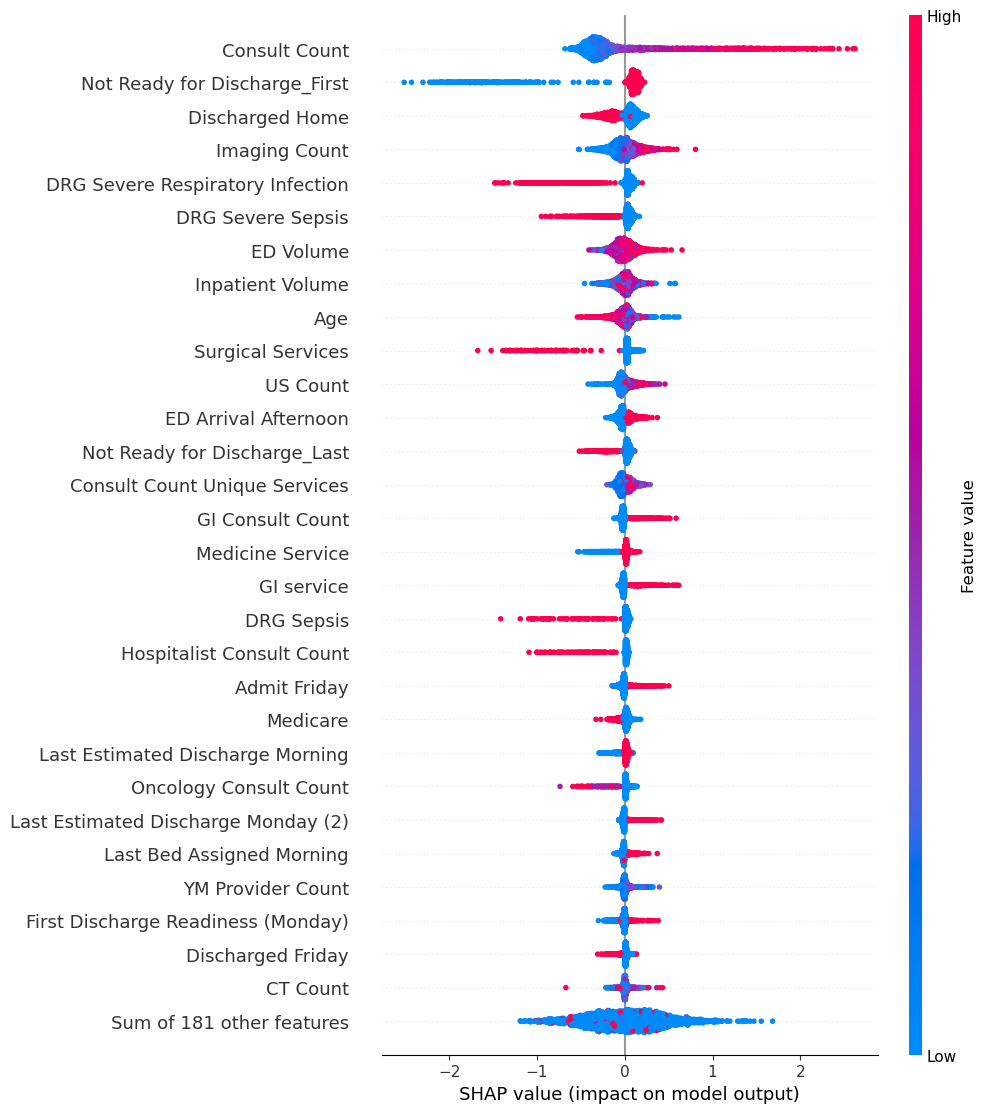

In [10]:
# Generate the Beeswarm plot
fig_beeswarm = plt.figure(figsize=(20, 20))  # Adjusted figure size for beeswarm
shap.plots.beeswarm(shap_values, max_display=30, show=False)

# Show the plot
plt.show()

<Axes: xlabel='mean(|SHAP value|)'>

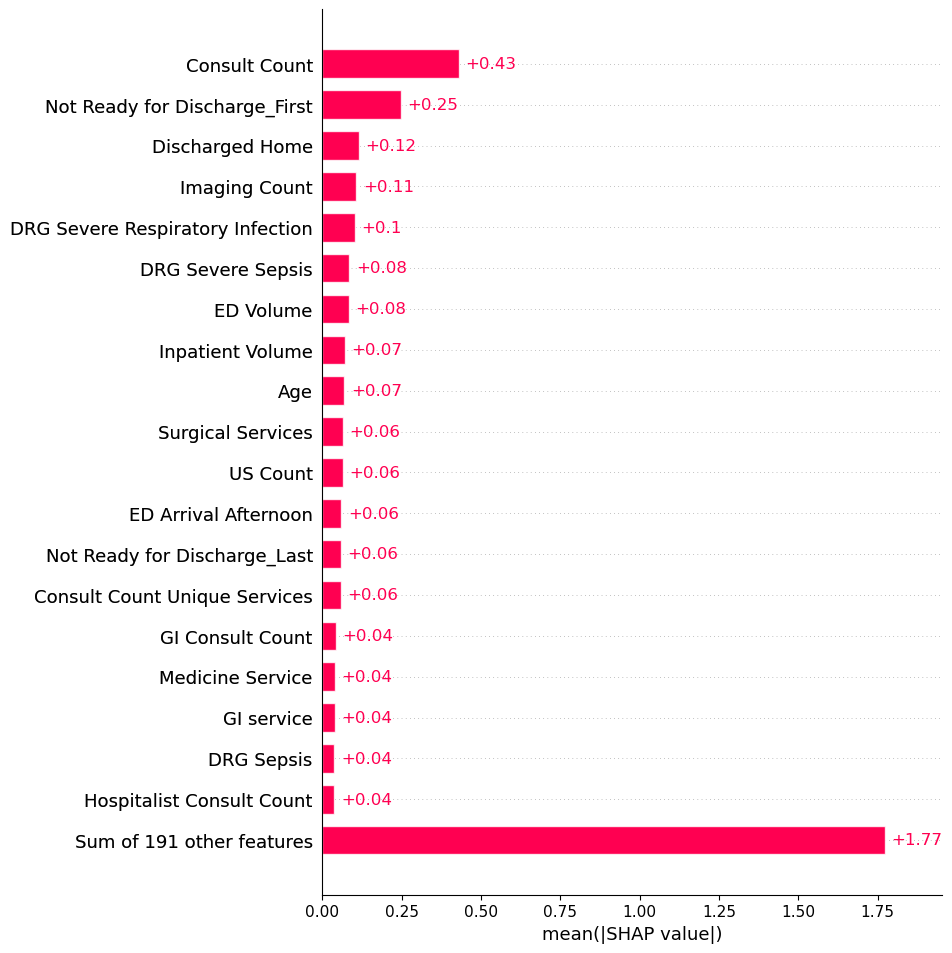

In [13]:
shap.plots.bar(shap_values, max_display=20, show=False)

In [ ]:
plt.figure()
plt.subplot(1,2,1)
shap.plots.beeswarm(shap_values, max_display=10, show=False)
plt.subplot(1,2,2)
shap.plots.bar(shap_values, show=False)

# Optional for adjusting the margins:
plt.subplots_adjust(
    left=1,
    bottom=0.1, 
    right=3, 
    top=0.9,
    wspace=0.5   
)

In [16]:
import numpy as np

# Step 1: Sum SHAP values across features per observation
shap_sums = shap_values.values.sum(axis=1)

# Step 2: Get indices sorted by highest predicted LOS (i.e., most positive SHAP sum)
top_100_indices = np.argsort(-shap_sums)[:100]  # negative sign for descending order

print("Top 100 indices with highest predicted LOS:")
print(top_100_indices)



Top 100 indices with highest predicted LOS:
[ 601  638 2079   40 1014 1873 1420 1158 1859 1779 1781 1011  180 1112
 1178 1363 1679 1769  595 1563  629  108 1786  275 2483 1118 1740  204
 1871 1013 2135 1286 2019 1807 2131 1748 1148 1707 2090 1225  563 2255
 2474   72  279 2244  936 1735 1206  336 1666  683 1332  422  522  855
   31 2004 2319 1539  509 1193 1113 1132 1604 2113  766 1623  462 2232
 1051   96 1213 1981  402 2177  815 1071  731 1224  909 1825  312 1155
 2264 1089  799  896   93  341 2219 1238  334  775 1073 2159 1119 1222
 1391  901]


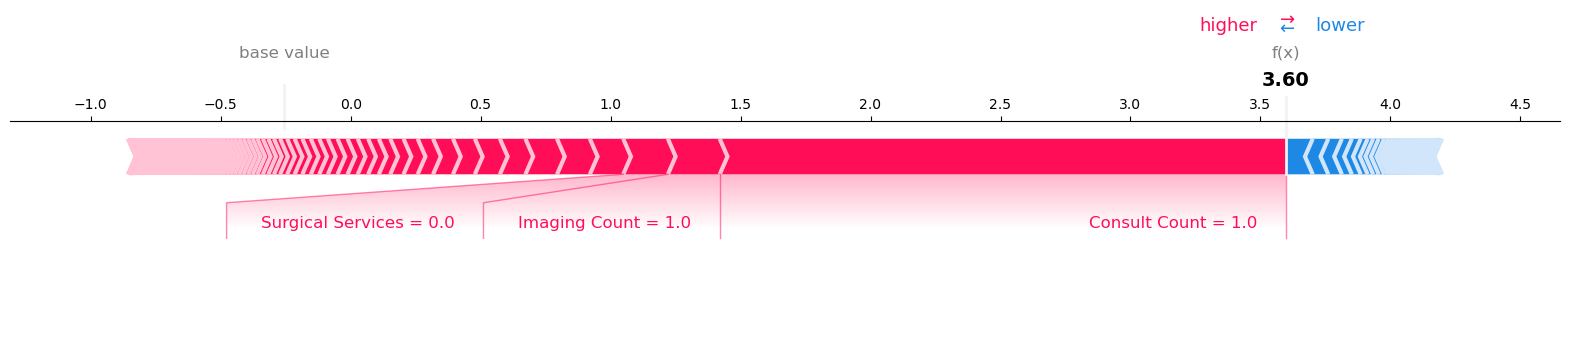

In [18]:
shap.force_plot(
    explainer.expected_value, shap_values[2079].values, X_test.iloc[0, :], matplotlib=True
)

## Other Plots 
- age, consult counts, imaging counts, ed volume, hospital volume

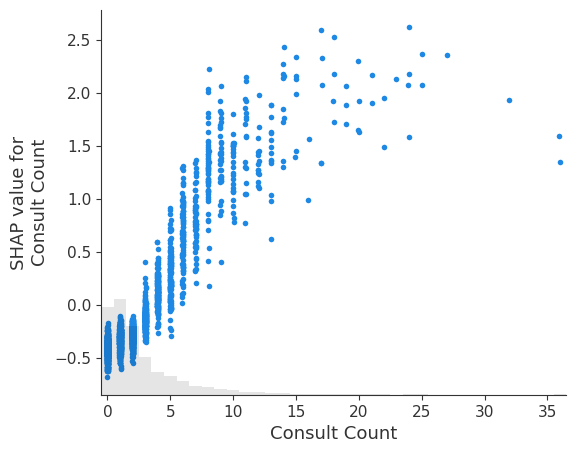

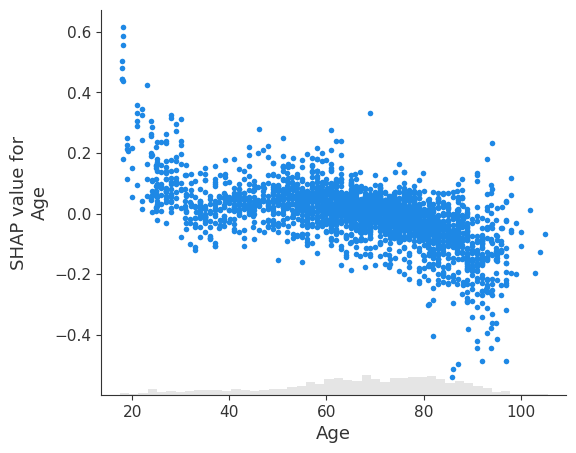

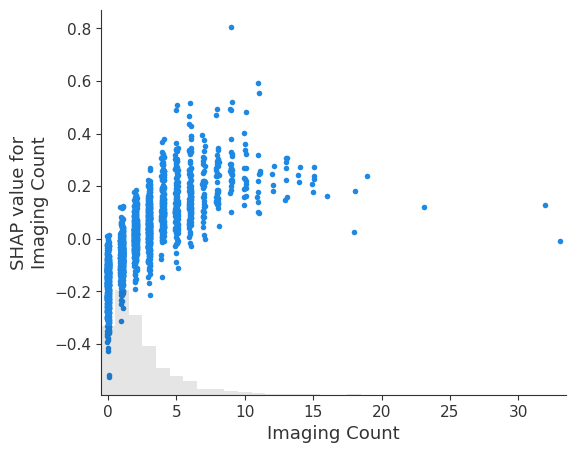

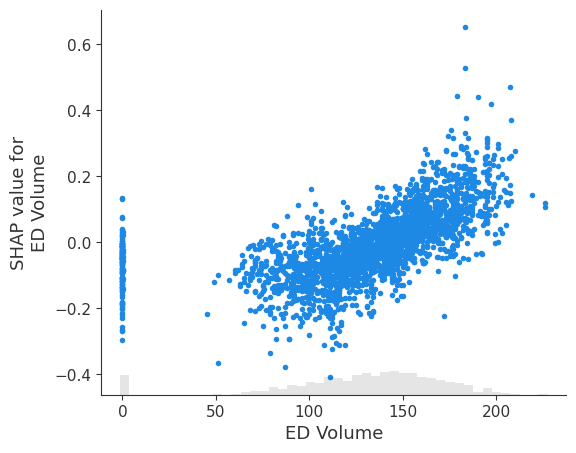

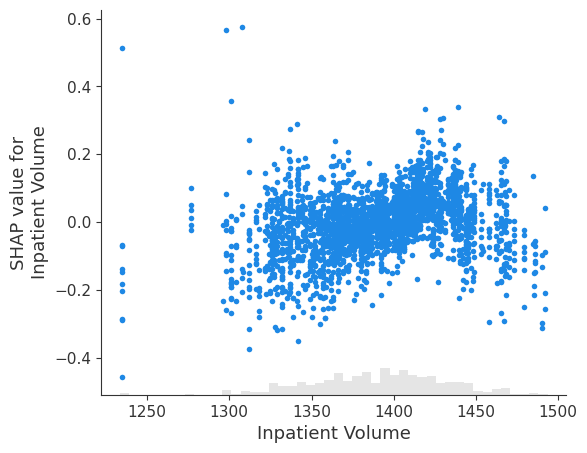

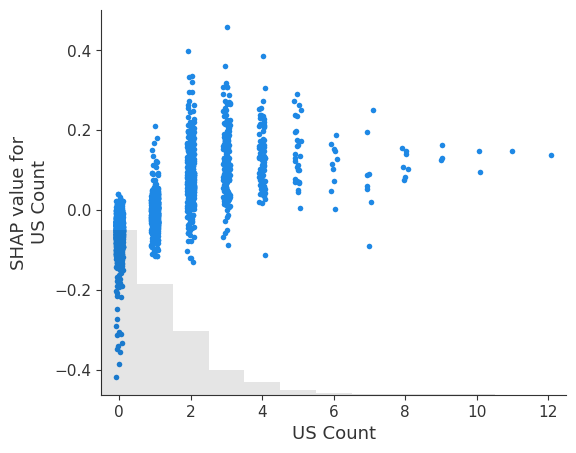

In [21]:
import shap
import matplotlib.pyplot as plt

# Extract feature names and SHAP values
feature_names = ["Consult Count", "Age", "Imaging Count", "ED Volume", "Inpatient Volume","US Count"]
                 
for feature in feature_names:
    shap.plots.scatter(shap_values[:, feature])

In [ ]:
import shap
import matplotlib.pyplot as plt

# Extract feature names and SHAP values
feature_names = ["Consult Count", "Age", "Imaging Count", "ED Volume", "US Count","Inpatient Volume"]

# Create a figure with 3 rows and 2 columns
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 14))

# Flatten the axes array for easy iteration
for ax, feature in zip(axes.flatten(), feature_names):
    shap.bplots.scatter(shap_values[:, feature], ax=ax)

plt.show()


# Log-Odds

In [1]:

def View(df, rows=None, cols=None, width=None):
    """Displays the first `rows` of the DataFrame like R's View() by adjusting Pandas settings."""
    
    # Show only the first `rows` of the DataFrame
    with pd.option_context(
        "display.max_rows", rows,  # Limit number of rows shown
        "display.max_columns", cols,  # Show all columns
        "display.max_colwidth", width,  # Show full column width
        "display.expand_frame_repr", False  # Prevent column wrapping
    ):
        display(df.head(rows))  # Show only the first `rows`
import pickle
import shap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# File paths
fp_simple = '/gpfs/milgram/project/rtaylor/imc33/LOS/output/model_simple.pkl'
fp_val = '/gpfs/milgram/project/rtaylor/imc33/LOS/output/X_val_selected.csv'
lab_df = pd.read_csv('/gpfs/milgram/project/rtaylor/imc33/LOS/data/new_label_names.csv')

# Create rename dictionary from lab_df
rename_dict = pd.Series(lab_df.new_name.values, index=lab_df.old_name).to_dict()

# Load the model
with open(fp_simple, "rb") as f:
    model = pickle.load(f)

# Load dataset
X_test = pd.read_csv(fp_val, index_col='pat_enc_csn_id')
y_test = pd.read_csv('/gpfs/milgram/project/rtaylor/imc33/LOS/output/X_val_selected.csv')

# Ensure feature order matches what the model expects
#X_test = X_test[model.feature_names_in_]

# Confirm features are identical
#print("Feature order matches:", list(model.feature_names_in_) == list(X_test.columns))

# Rename feature columns using rename_dict while ensuring uniqueness
X_test = X_test.rename(columns=rename_dict)

# Check for duplicate column names and resolve by appending a suffix
counts = {}
new_columns = []
for col in X_test.columns:
    if col in counts:
        counts[col] += 1
        new_columns.append(f"{col} ({counts[col]})")  # Append count to make unique
    else:
        counts[col] = 1
        new_columns.append(col)

X_test.columns = new_columns  # Update column names to be unique


In [35]:
y_test = pd.read_csv('/gpfs/milgram/project/rtaylor/imc33/LOS/output/y_val.csv', index_col='pat_enc_csn_id')
y_test = y_test.loc[X_test.index]


In [2]:
# Compute SHAP values
explainer = shap.TreeExplainer(model, feature_perturbation="tree_path_dependent")
shap_values = explainer(X_test)  # Compute SHAP values

# Ensure SHAP values use the renamed features
shap_values.feature_names = X_test.columns.tolist()

In [37]:
from sklearn.utils import resample
import numpy as np
import pandas as pd

# Define your bootstrap CI function
def bootstrap_shap_ci(shap_vals, n_boot=1000, alpha=0.05):
    means = []
    for _ in range(n_boot):
        sample = resample(shap_vals)
        means.append(np.mean(sample))
    lower = np.percentile(means, 100 * alpha / 2)
    upper = np.percentile(means, 100 * (1 - alpha / 2))
    return lower, upper

# Get SHAP values array and feature names
shap_array = shap_values.values  # (n_samples x n_features)
features = X_test.columns

# Initialize lists to store results
mean_shap = []
ci_lowers = []
ci_uppers = []

# Loop through each feature
for i, feat in enumerate(features):
    col_vals = shap_array[:, i]
    mean_shap.append(np.mean(col_vals))
    ci_low, ci_high = bootstrap_shap_ci(col_vals)
    ci_lowers.append(ci_low)
    ci_uppers.append(ci_high)

# Create DataFrame
impact_df = pd.DataFrame({
    'feature': features,
    'log_odds': mean_shap,
    'log_lower': ci_lowers,
    'log_upper': ci_uppers
}).sort_values(by='log_odds', key=np.abs, ascending=False)

impact_df

,feature,log_odds,log_lower,log_upper
3,Consult Count,-0.053837,-0.077462,-0.031967
166,Not Ready for Discharge_First,-0.040498,-0.059968,-0.021764
171,First Discharge Readiness (Monday),-0.009892,-0.011800,-0.008018
54,Discharged Home,-0.007526,-0.013002,-0.002461
167,"summary_first_rfd_status_Yes, with barriers",-0.006900,-0.008898,-0.004831
...,...,...,...,...
189,con_max_consult_note_creation_time_Morning,-0.000008,-0.001140,0.001017
15,con_service_geriatrics_count,-0.000006,-0.000387,0.000339
56,viz_ethnicity_Unknown,-0.000005,-0.000212,0.000153
113,First Bed Assigned Sunday,0.000003,-0.000578,0.000573


In [38]:
impact_df['or'] = np.exp(impact_df['log_odds'])
impact_df['or_lower'] = np.exp(impact_df['log_lower'])
impact_df['or_upper'] = np.exp(impact_df['log_upper'])

In [43]:
impact_df.sort_values(by='or', ascending=False)

,feature,log_odds,log_lower,log_upper,or,or_lower,or_upper,sig
25,Oncology Consult Count,0.006636,0.003846,0.009195,1.006658,1.003853,1.009238,True
187,summary_last_rfd_day_Mon,0.004291,0.003611,0.005036,1.004300,1.003618,1.005048,True
73,GI service,0.002840,0.000041,0.005766,1.002844,1.000041,1.005782,True
6,YM Provider Count,0.002831,0.001187,0.004642,1.002835,1.001187,1.004652,True
20,con_service_infectious_disease_count,0.002522,0.001763,0.003276,1.002525,1.001764,1.003281,True
...,...,...,...,...,...,...,...,...
167,"summary_first_rfd_status_Yes, with barriers",-0.006900,-0.008898,-0.004831,0.993124,0.991142,0.995181,True
54,Discharged Home,-0.007526,-0.013002,-0.002461,0.992502,0.987083,0.997542,True
171,First Discharge Readiness (Monday),-0.009892,-0.011800,-0.008018,0.990156,0.988269,0.992014,True
166,Not Ready for Discharge_First,-0.040498,-0.059968,-0.021764,0.960311,0.941795,0.978471,True


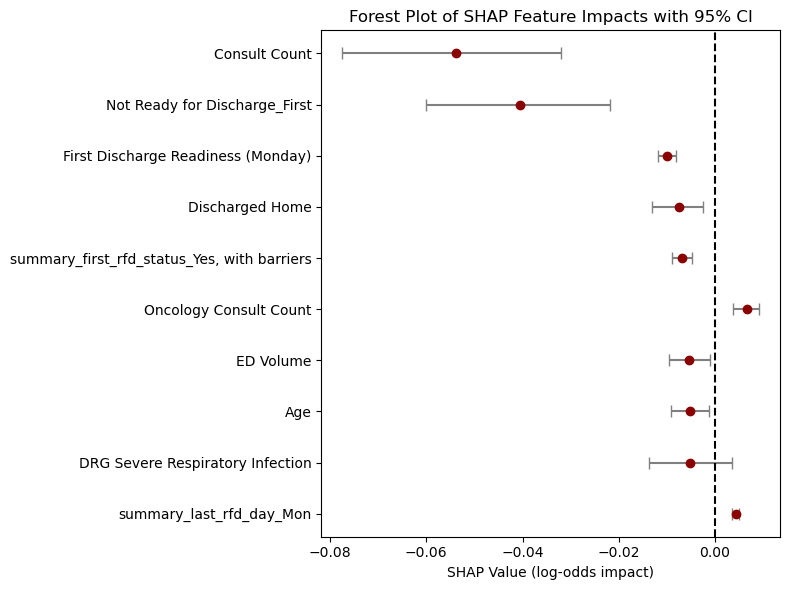

In [45]:
import matplotlib.pyplot as plt

# Select top N features
top_n = 10
df_plot = impact_df.sort_values(by='log_odds', key=np.abs, ascending=False).head(top_n)
df_plot = df_plot[::-1]  # flip for top-to-bottom order

# Plot
plt.figure(figsize=(8, 6))
plt.errorbar(
    x=df_plot['log_odds'],
    y=df_plot['feature'],
    xerr=[df_plot['log_odds'] - df_plot['log_lower'],
          df_plot['log_upper'] - df_plot['log_odds']],
    fmt='o', color='darkred', ecolor='gray', capsize=4
)

plt.axvline(0, color='black', linestyle='--')
plt.xlabel('SHAP Value (log-odds impact)')
plt.title('Forest Plot of SHAP Feature Impacts with 95% CI')
plt.tight_layout()
plt.show()


In [46]:
impact_df.to_csv("../output/log_odds.csv", index=False)